
<font size = "5"> **Day 1: [Atomic Resolution STEM and Machine Learning](../MLSTEM2025.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />



[Download](https://github.com/gduscher/MLSTEM2025/raw/refs/heads/main/Day%201/4_Acquire_Images.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
   https://colab.research.google.com/github/gduscher/MLSTEM2025/blob/main/Day%201/_Acquire_Images.ipynb)
   

# Aberration Correction 

part of the workshop of 

<font size = "5"> **[Machine Learning in Transmission Electron Microscopy](../MLSTEM2025.ipynb)**</font>


**Day1: Atomic Resolution STEM,**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**May 2025**

Main Contributer to Notebook: Utkarsh Pratish

## Import packages for figures and 
First we load the code to make figures from pyTEMlib
### Check Installed Packages



In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2025.4.1':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

done


This notebook needs a jupyter kernel of python 3.10 for Autoscript compatibility

<div class="alert alert-block alert-info">
<b>Tip:</b> Please note that the AutoScript and CEOSacquisition are not freely available.
</div>
If you have the packages installed on your computer you need to include the path to the system (sys.path.insert)

In [4]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy  as np

import sys
sys.path.insert(0, "..//..//Autoscript//")
from autoscript_tem_microscope_client import TemMicroscopeClient
from autoscript_tem_microscope_client.enumerations import *
from autoscript_tem_microscope_client.structures import *
from autoscript_tem_microscope_client.structures import RunOptiStemSettings

%load_ext autoreload
%autoreload 2
sys.path.insert(0, "..//..//pyTEMlib//")
import pyTEMlib
import pyTEMlib.probe_tools
import pyTEMlib.file_tools

print('pyTEMlib version: ', pyTEMlib.__version__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
pyTEMlib version:  0.2025.04.1


## Connection to our microscope

We connect to 
- Autoscript

In [5]:
ip = "10.46.217.241" 
port_TF = 9095

In [6]:
microscope = TemMicroscopeClient()
microscope.connect(ip, port=port_TF)
print("Connected to the microscope")

Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]
Connected to the microscope


## Check Vacuum

In [7]:
print("microscope vacumm is:",microscope.vacuum.state)
print("column valve is: ", microscope.vacuum.column_valves.state)

microscope vacumm is: Ready
column valve is:  Opened


### Open column valve
If everything is okay we can open the column valve

In [8]:
microscope.vacuum.column_valves.open()

StagePosition(x=-14.11869, y=57.394002, z=-65.51904, a=-3.136)


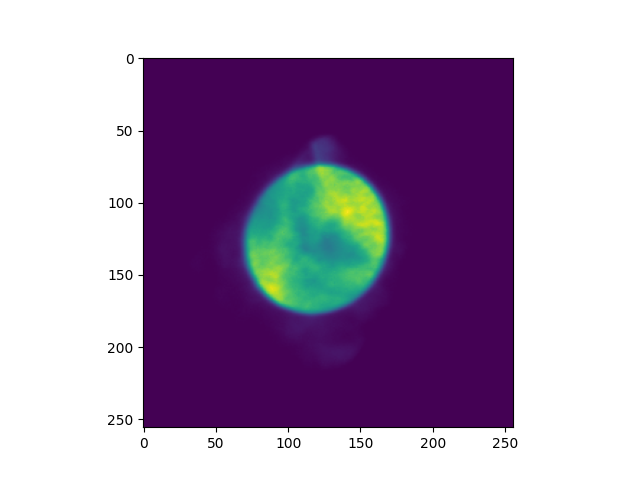

In [9]:
microscope.specimen.stage.relative_move([0,0, 0e-6])
print(microscope.specimen.stage.position*1e6)
image = microscope.acquisition.acquire_camera_image("Flucam", 1024, .02);
plt.figure()
plt.imshow(image.data[384:640, 384:640])

## Focus with Sample Height

{'experiment': {'acceleration_voltage': 200000.0,
  'spot_size': '7',
  'detector': 'Flucam',
  'exposure_time': '0.02'}}

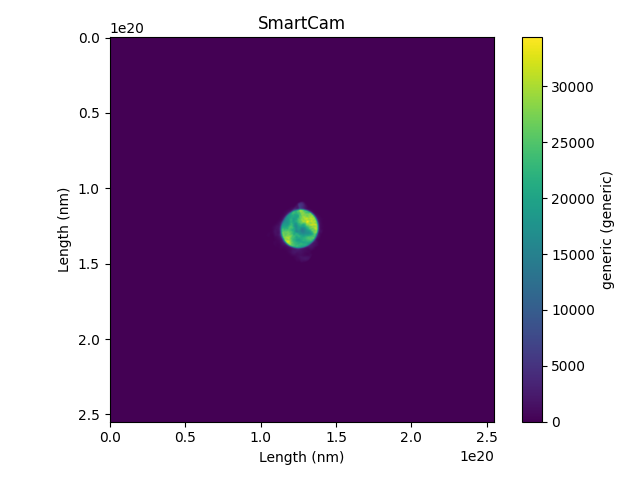

In [23]:
datasets = pyTEMlib.file_tools.adorned_to_sidpy(image)

v = datasets['Channel_000'].plot()

datasets['Channel_000'].metadata


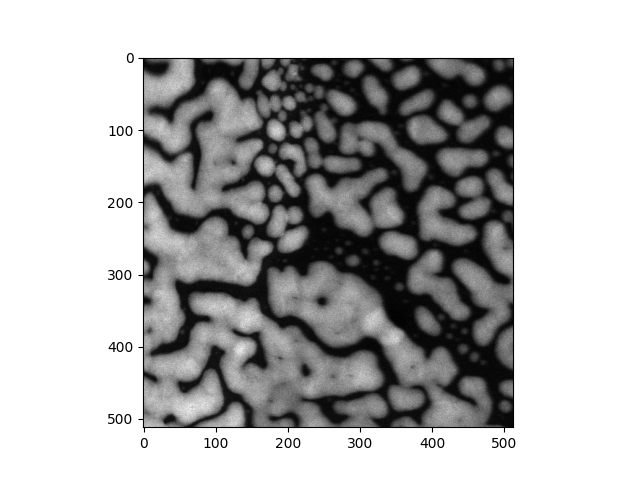

In [29]:
microscope.specimen.stage.relative_move([0, 0*1e-6, 0.1*1e-6])
microscope.optics.defocus = -0e-9
microscope.optics.scan_field_of_view  = .17*1e-6
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 4e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data, cmap='gray')



### Get Image

defocus: 0.0nm
condenser stigmator amplitude: 0.00 angle: 0.0


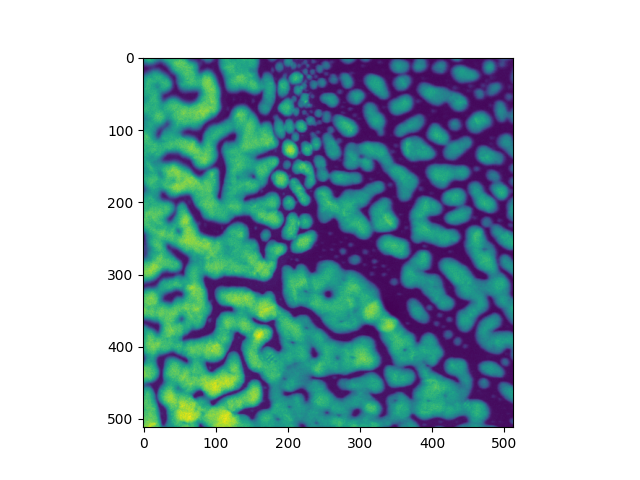

In [30]:
plt.close('all')
# microscope.optics.defocus = -27e-9
print(f"defocus: {microscope.optics.defocus*1.e9:.1f}nm")
print(f"condenser stigmator amplitude: { microscope.optics.stigmators.condenser_stigmator.magnitude():.2f}"+
      f" angle: {microscope.optics.stigmators.condenser_stigmator.angle():.1f}")
microscope.optics.scan_field_of_view  = 200*1e-9
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 16e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)


In [13]:
microscope.optics.stigmators.condenser_stigmator.magnitude()

0.009901267342250452

### Focus and Stigmation with OptiSTEM

defocus: -7.3nm


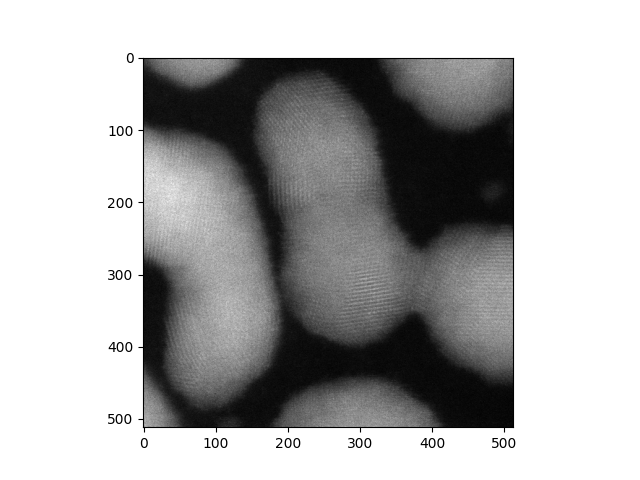

In [62]:
microscope.optics.scan_field_of_view  = 20*1e-9

settings = RunOptiStemSettings(method=OptiStemMethod.C1_A1, dwell_time=5*1e-6, cutoff_in_pixels=5)
microscope.auto_functions.run_opti_stem(settings)
print(f"defocus: {microscope.optics.defocus*1.e9:.1f}nm")
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 4e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data, cmap='gray')


In [32]:
print(f"condenser stigmator amplitude: { microscope.optics.stigmators.condenser_stigmator.magnitude():.5f}"+
      f" angle: {np.degrees(microscope.optics.stigmators.condenser_stigmator.angle()):.1f}")


condenser stigmator amplitude: 0.00437 angle: -64.4


### Take high resolution Image

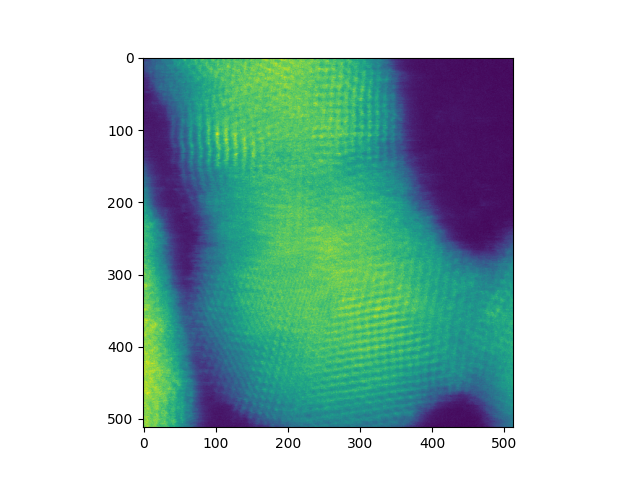

In [64]:
microscope.specimen.stage.relative_move([0, -.0*1e-6, 0*1e-6])
#microscope.optics.defocus = -39e-9
microscope.optics.scan_field_of_view  = 10*1e-9
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 16e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)

### Look at FFT

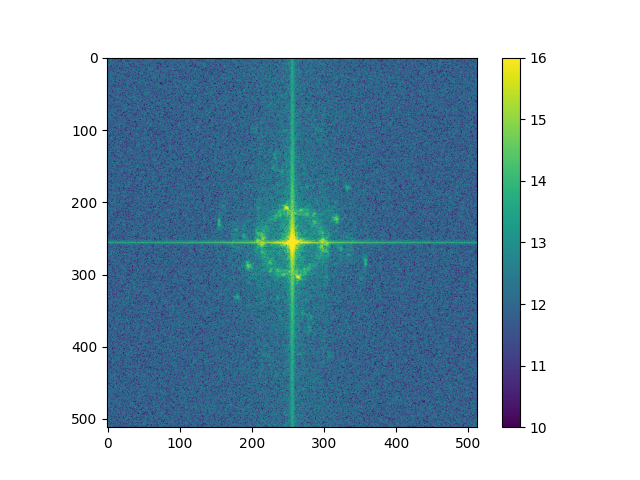

In [65]:
import numpy as np
fft_image = np.fft.fftshift(np.fft.fft2(haadf_image.data))

plt.figure()
plt.imshow(np.log(100+np.abs(fft_image)), vmin=10, vmax=16)
plt.colorbar()



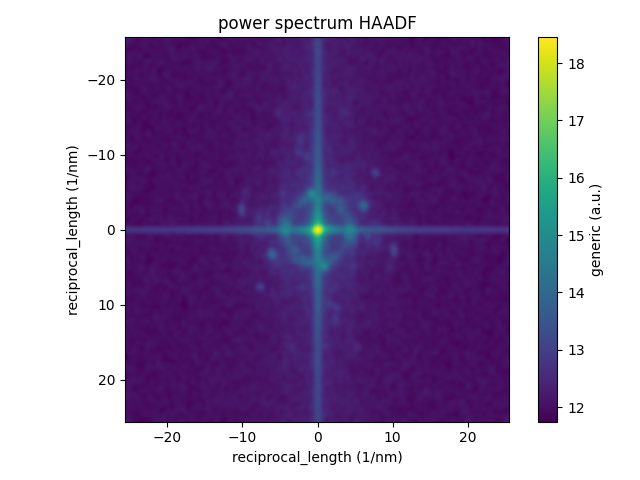

In [69]:
datasets = pyTEMlib.file_tools.adorned_to_sidpy(haadf_image)
haadf_fft = pyTEMlib.image_tools.power_spectrum(datasets['Channel_000'])
v = haadf_fft.plot()

## Get a Stack of Images

In [71]:
# --- Input ----
size = 512
stack_size = 10
defous_spread =20
# ---------------------

from tqdm.auto import trange

defocus = microscope.optics.defocus
microscope.optics.defocus -= 10e-9
haadf_stack2 = np.zeros([20,size,size])
for i in trange(10):
    microscope.optics.defocus += 2e-9
    haadf_stack2[i] = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, size,4e-6).data# haadf is pixel wise
microscope.optics.defocus = defocus


  0%|          | 0/10 [00:00<?, ?it/s]

## Get images with different detectors

In [79]:
bf_s = microscope.detectors.get_scanning_detector(DetectorType.BF_S)
df_s = microscope.detectors.get_scanning_detector(DetectorType.DF_S)
haadf = microscope.detectors.get_scanning_detector(DetectorType.HAADF)

# Enable the inner segments on the BF-S detector
bf_s.set_enabled_segments(DetectorSegmentType.INNER_RING)

# Enable all segments on the DF-S detector
df_s.set_enabled_segments(DetectorSegmentType.INNER_RING)

haadf.set_enabled_segments(DetectorSegmentType.SINGLE)
# Join the two lists together
segments = bf_s.get_enabled_segments() + df_s.get_enabled_segments() + haadf.get_enabled_segments()

# Acquire one image per segment, a total of 13 images in this case
images = microscope.acquisition.acquire_stem_segment_images(segments, 256, 1E-6)

In [80]:
datasets2 = pyTEMlib.file_tools.adorned_to_sidpy(images)
chooser = pyTEMlib.file_tools.ChooseDataset(datasets2)

Dropdown(description='select dataset:', options=('Channel_000: HAADF', 'Channel_001: BF-S_Inner1', 'Channel_00…

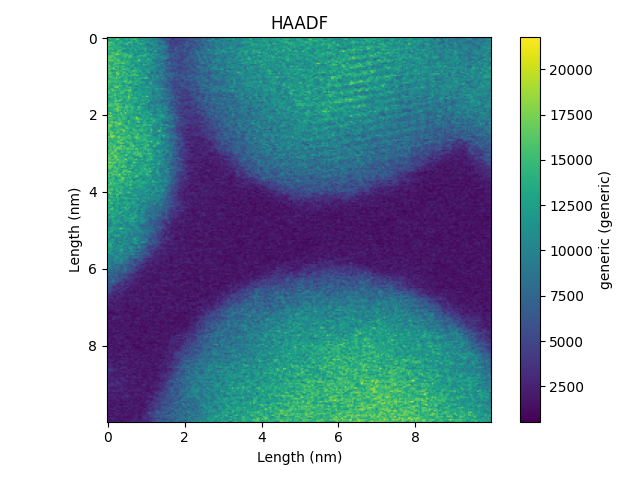

In [82]:
dataset = chooser.dataset

view = dataset.plot()


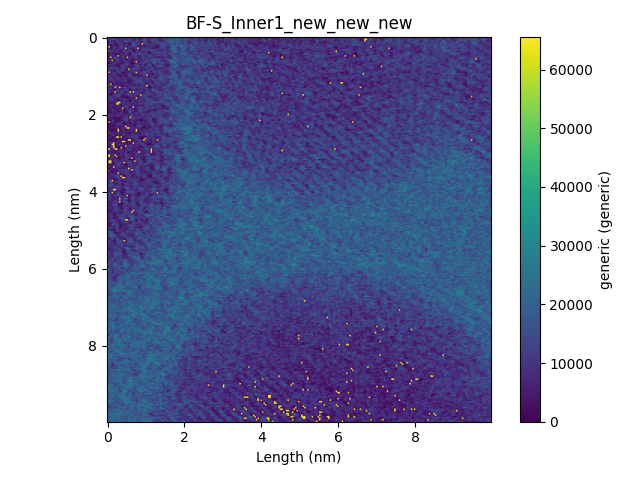

In [83]:
bf = datasets2['Channel_001']+datasets2['Channel_002']+datasets2['Channel_003']+datasets2['Channel_004']
view = bf.plot()


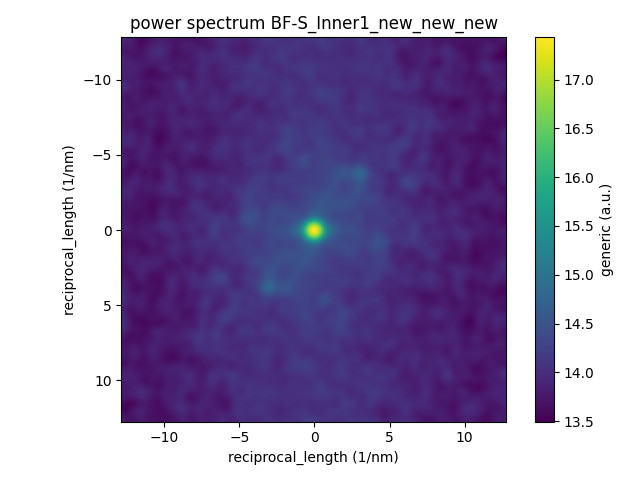

In [84]:
fft_bf = pyTEMlib.image_tools.power_spectrum(bf)
v = fft_bf.plot()

## End Session

In [95]:
microscope.detectors.screen.insert()

microscope.detectors.screen.measure_current()
microscope.optics.unblank()

In [93]:
dir(microscope.optics.unblank())

['__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [96]:
import collections
def etree_to_dict(element):
    """Recursively converts an ElementTree object into a nested dictionary."""
    d = {element.tag: {} if element.attrib else None}
    children = list(element)
    if children:
        dd = collections.defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {element.tag: {k: v[0] if len(v) == 1 else v for k, v in dd.items()}}
    if element.attrib:
        d[element.tag].update(('@' + k, v) for k, v in element.attrib.items())
    if element.text:
        text = element.text.strip()
        if children or element.attrib:
            if text:
                d[element.tag]['#text'] = text
        else:
            d[element.tag] = text
    return d

In [99]:
import sidpy
import numpy as np
import xml.etree.ElementTree as ET
# from stemOrchestrator.process import etree_to_dict
from sidpy.sid import Dimension

def adorned_to_sidpy(image)
xml_str = image_with_metadata.metadata.metadata_as_xml
root = ET.fromstring(xml_str)
metadata_dict = etree_to_dict(root)

image = image_with_metadata.data
data_sets = {'Channel_000': sidpy.Dataset.from_array(image.T, name="HAADF")}
data_sets['Channel_000'].data_type = 'image'

ds = data_sets['Channel_000']

ds.original_metadata = metadata_dict['Metadata']

pixel_size_x_m = float(ds.original_metadata['BinaryResult']['PixelSize']['X']['#text'])
pixel_size_y_m = float(ds.original_metadata['BinaryResult']['PixelSize']['Y']['#text'])
pixel_size_x_um = pixel_size_x_m * 1e6
pixel_size_y_um = pixel_size_y_m * 1e6

ds.set_dimension(
    0,
    Dimension(np.arange(image.shape[0]) * pixel_size_y_um,
              name='y', units='µm', quantity='Length', dimension_type='spatial')
)

ds.set_dimension(
    1,
    Dimension(np.arange(image.shape[1]) * pixel_size_x_um,
              name='x', units='µm', quantity='Length', dimension_type='spatial')
)

# ds.metadata['note'] = 'The shape of overview image and spectrum image are different in 1st 2 dimensions, possibly due to binning.'





In [125]:
microscope.detectors.screen.insert()

dir(microscope.acquisition)# .scanning_detector()

['_Acquisition__application_client',
 '_Acquisition__id',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 'acquire_camera_image',
 'acquire_camera_image_advanced',
 'acquire_camera_series',
 'acquire_camera_series_advanced',
 'acquire_stem_data',
 'acquire_stem_image',
 'acquire_stem_images',
 'acquire_stem_images_advanced',
 'acquire_stem_segment_images']

In [118]:
for detector_name in microscope.detectors.scanning_detectors:
    detector = microscope.detectors.get_scanning_detector(detector_name)

    # print the name of the detector
    print(detector.display_name)

BF-S
DF-S
HAADF


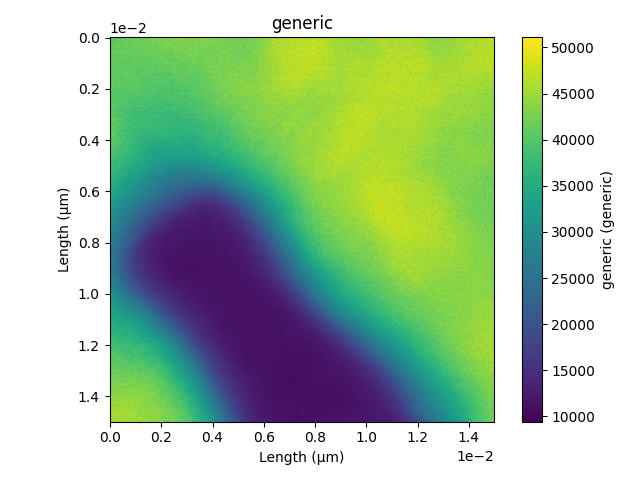

In [197]:
v = ds.plot()

In [144]:
#microscope.specimen.stage.absolute_move([0,0, 0])
print(microscope.specimen.stage.position*1e6)
microscope.vacuum.column_valves.close()

StagePosition(x=0.002625, y=-0.004482, z=0.00111, a=99.068)


In [131]:
help(microscope.acquisition.acquire_stem_segment_images) #(DetectorType.DF2, 512, 3e-6)

Help on method acquire_stem_segment_images in module autoscript_tem_microscope_client.tem_microscope._acquisition:

acquire_stem_segment_images(detector_segments: 'List[DetectorSegment]', size: 'int', dwell_time: 'float') -> 'List[AdornedImage]' method of autoscript_tem_microscope_client.tem_microscope._acquisition.Acquisition instance
    Acquires images from scanning detector segments.
    
    :param detector_segments: The list of detector segments.
    
    :param size: The size of one of the sides of the (square) image in pixels. Enumeration ImageSize can be used.
    
    :param dwell_time: The dwell time in seconds.
    
    :return: The list of images. The order of the images in the list corresponds to the order of the segments in the input array.



In [188]:
bf_s = microscope.detectors.get_scanning_detector(DetectorType.BF_S)
df_s = microscope.detectors.get_scanning_detector(DetectorType.DF_S)
haadf = microscope.detectors.get_scanning_detector(DetectorType.HAADF)

# Enable the inner segments on the BF-S detector
bf_s.set_enabled_segments(DetectorSegmentType.INNER_RING)

# Enable all segments on the DF-S detector
df_s.set_enabled_segments(DetectorSegmentType.INNER_RING)

haadf.set_enabled_segments(DetectorSegmentType.SINGLE)
# Join the two lists together
segments = bf_s.get_enabled_segments() + df_s.get_enabled_segments() + haadf.get_enabled_segments()

# Acquire one image per segment, a total of 13 images in this case
images = microscope.acquisition.acquire_stem_segment_images(segments, 256, 1E-6)


In [198]:
xml_str = images[0].metadata.metadata_as_xml
root = ET.fromstring(xml_str)
metadata_dict = etree_to_dict(root)
detector = ''
segment = ''
for list_item in metadata_dict['Metadata']['CustomPropertyGroup']['CustomProperties']:
    
    if isinstance(list_item, dict):
        for key in list_item:
            for item in list_item[key]:
                if '@name' in item:
                    if item['@name']==  'DetectorCommercialName':
                        detector = item['@value']
                    if item['@name']== 'StemSegment':
                        segment = item['@value']
detector+segment

'HAADF'

In [246]:
import sidpy
import numpy as np
import xml.etree.ElementTree as ET
# from stemOrchestrator.process import etree_to_dict
from sidpy.sid import Dimension

def read_adorned_metadata(image):
    xml_str = image.metadata.metadata_as_xml
    root = ET.fromstring(xml_str)
    metadata_dict = etree_to_dict(root)
    detector = 'detector'
    if 'Detectors' in metadata_dict['Metadata']['Detectors']['ScanningDetector']:
        if 'ScanningDetector' in metadata_dict['Metadata']['Detectors']['ScanningDetector']:
            detector = metadata_dict['Metadata']['Detectors']['ScanningDetector']['DetectorName']

    segment = ''
    if 'CustomPropertyGroup' in  metadata_dict['Metadata']:
        if 'CustomProperties' in metadata_dict['Metadata']['CustomPropertyGroup']:
            for list_item in metadata_dict['Metadata']['CustomPropertyGroup']['CustomProperties']:
                
                if isinstance(list_item, dict):
                    for key in list_item:
                        for item in list_item[key]:
                            if '@name' in item:
                                if item['@name']==  'DetectorCommercialName':
                                    detector = item['@value']
                                if item['@name']== 'StemSegment':
                                    segment = '_'+item['@value']
    return detector+segment, metadata_dict['Metadata']

def adorned_to_sidpy(images):
    
    data_sets = {}
    if not isinstance(images, list):
        images = [images]
    for index, image in enumerate(images):
        name, original_metadata = read_adorned_metadata(image)
        data_sets[f'Channel_{index:03}'] = sidpy.Dataset.from_array(image.data.T, title=name)
        ds = data_sets[f'Channel_{index:03}']
        

        ds.original_metadata = original_metadata

        pixel_size_x_m = float(ds.original_metadata['BinaryResult']['PixelSize']['X']['#text'])
        pixel_size_y_m = float(ds.original_metadata['BinaryResult']['PixelSize']['Y']['#text'])
        pixel_size_x_nm = pixel_size_x_m * 1e9
        pixel_size_y_nm = pixel_size_y_m * 1e9
        if image.data.ndim == 3:
            ds.data_type = 'image_stack'
            ds.set_dimension(0, Dimension(np.arange(image.data.shape[0]),
                                           name='frame', units='frame', quantity='Length', dimension_type='temporal'))
            ds.set_dimension(1, Dimension(np.arange(image.data.shape[1]) * pixel_size_y_nm,
                                          name='y', units='nm', quantity='Length', dimension_type='spatial'))
            ds.set_dimension(2, Dimension(np.arange(image.data.shape[2]) * pixel_size_x_nm,
                                          name='x', units='nm', quantity='Length', dimension_type='spatial'))        
        else:         
            ds.data_type = 'image'
            ds.set_dimension(0, Dimension(np.arange(image.data.shape[0]) * pixel_size_y_nm,
                                          name='y', units='nm', quantity='Length', dimension_type='spatial'))   
            ds.set_dimension(1, Dimension(np.arange(image.data.shape[1]) * pixel_size_x_nm,
                                          name='x', units='nm', quantity='Length', dimension_type='spatial'))

    return data_sets

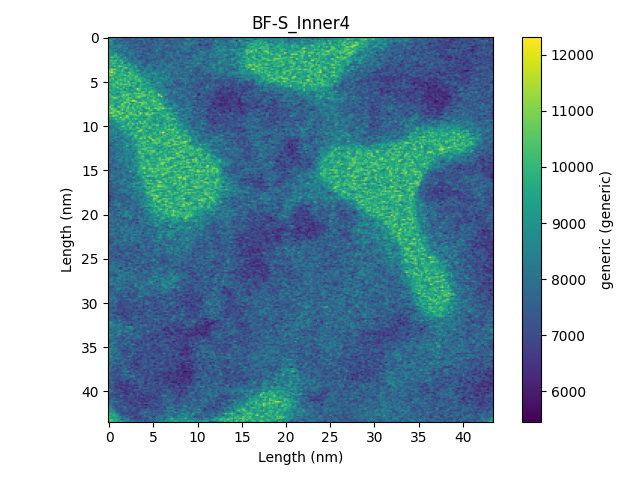

In [255]:
dsets = pyTEMlib.file_tools.adorned_to_sidpy(images)
v = dsets['Channel_004'].plot()



In [204]:
metadata_dict['Metadata']['Detectors']['ScanningDetector']

{'DetectorName': 'HAADF',
 'DetectorType': 'ScanningDetector',
 'Inserted': 'true',
 'Signal': 'SE',
 'Gain': '29.4230147',
 'Offset': '-1.752'}

In [142]:
df_s.set_enabled_segments(DetectorSegmentType.ALL)

df_s.get_enabled_segments()

[DetectorSegment(DF-S.Inner1),
 DetectorSegment(DF-S.Inner2),
 DetectorSegment(DF-S.Inner3),
 DetectorSegment(DF-S.Inner4),
 DetectorSegment(DF-S.Outer1),
 DetectorSegment(DF-S.Outer2),
 DetectorSegment(DF-S.Outer3),
 DetectorSegment(DF-S.Outer4)]

In [141]:
dir(DetectorSegmentType)

['ALL',
 'INNER1',
 'INNER2',
 'INNER3',
 'INNER4',
 'INNER_RING',
 'OUTER1',
 'OUTER2',
 'OUTER3',
 'OUTER4',
 'OUTER_RING',
 'SEGMENT1',
 'SEGMENT2',
 'SEGMENT3',
 'SEGMENT4',
 'SINGLE',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'explain',
 'get_all_items']

In [ ]:
apertures = microscope.optics.aperture_mechanisms.C2.apertures
print(apertures)
microscope.optics.aperture_mechanisms.C2.aperture = apertures[1]

aperture = microscope.optics.aperture_mechanisms.C2.aperture
print("Name: ", aperture.name)
print("Type: ", aperture.type)
print("Diameter:", aperture.diameter)